In [1]:
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import utilis

import keras_ocr

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

# tf.config.list_physical_devices('GPU')

# assert tf.test.is_gpu_available()

In [2]:
dataset_labels = utilis.get_labels_dataset()[:-300]
print("Dataset len:", len(dataset_labels))
dataset_labels[:2]

Dataset len: 2168


[('image_dataset_test/img_842.png', None, 'pescara'),
 ('image_dataset_test/img_856.png', None, 'place')]

In [3]:
test_labels = utilis.get_labels_dataset()[2168:]
print("Test len:", len(test_labels))
test_labels[:2]

Test len: 300


[('image_dataset_test/img_2726.png', None, 'caravaggio'),
 ('image_dataset_test/img_2732.png', None, 'torino')]

In [4]:
# recognizer_alphabet = recognizer.alphabet
# recognizer_alphabet = recognizer_alphabet[:12] + './-()'+recognizer_alphabet[12:]
# recognizer_alphabet
alphabet = '0123456789ab./-()cdefghijklmnopqrstuvwxyz'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
recognizer_alphabet

'()-./0123456789abcdefghijklmnopqrstuvwxyz'

In [6]:
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()

Instructions for updating:
Colocations handled automatically by placer.


2024-02-24 16:48:18.423006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-02-24 16:48:18.441276: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/kernel/Assign' id:385 op device:{requested: '', assigned: ''} def:{{{node dense/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense/kernel, dense/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /Users/gmarini/.keras-ocr/crnn_kurapan_notop.h5


2024-02-24 16:48:18.999045: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_11/lstm_cell/bias/Assign' id:1392 op device:{requested: '', assigned: ''} def:{{{node lstm_11/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_11/lstm_cell/bias, lstm_11/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [7]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(dataset_labels, test_size=0.2, random_state=42)

print("Train len:", len(train_labels))
print("Train example:", train_labels[:2])
print("Validation len", len(validation_labels))


Train len: 1734
Train example: [('image_dataset_test/img_1008.png', None, 'aldo'), ('image_dataset_test/img_789.png', None, 'ordine')]
Validation len 434


In [8]:
batch_size = 8

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer_alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]

In [9]:
print(training_image_gen, training_steps)
print(validation_image_gen, validation_steps)

<generator object get_recognizer_image_generator at 0x28241e180> 216
<generator object get_recognizer_image_generator at 0x28241e880> 54


In [10]:
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: tionality


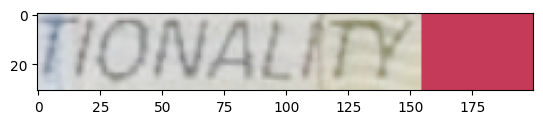

In [11]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

text: diritti


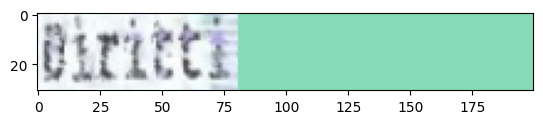

In [12]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

In [ ]:
# RECOGNIZER LOAD_MODEL / FIT
# recognizer.model = tf.keras.models.load_model('modelli_allenati/recogn_model_colab_05')

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=10,
)

/Users/gmarini/.pyenv/versions/3.10.6/envs/py_AutoQuote/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-22 16:42:38.977231: W tensorflow/c/c_api.cc:305] Operation '{name:'decode/PadV2' id:1958 op device:{requested: '', assigned: ''} def:{{{node decode/PadV2}} = PadV2[T=DT_INT64, Tpaddings=DT_INT32, _has_manual_control_dependencies=true](decode/SparseToDense, decode/PadV2/paddings, decode/PadV2/constant_values)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Predicted: e, Actual: e


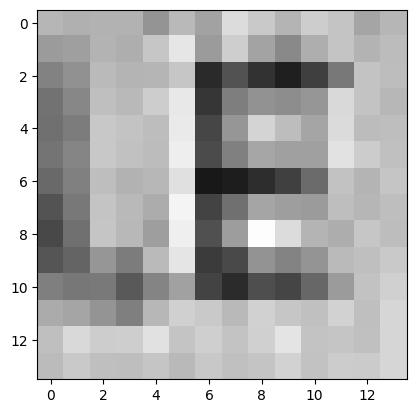

In [ ]:
image_filepath, _, actual = test_labels[np.random.randint(0,  len(test_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [ ]:
# SAVE MODEL
# recognizer.model.save('modelli_allenati/recognizer_model')